In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functools
import scipy.signal
from tqdm import tqdm
import inspect
import pickle
import sys
import json
import os
sys.path.append('../data_processing/')
sys.path.append('../validation/')
from feature import Feature
import dp_utils as dp
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score, mutual_info_score
from sklearn.preprocessing import StandardScaler

%matplotlib notebook

In [2]:
filepath = '../../data.nosync/train_short.h5'
df = pd.read_hdf(filepath, key='table')
df.head()

,s,ttf
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [3]:
Feature(df['s'], '../../data.nosync/')\
.w_periodogram(window_size=150000, window_stride=1000, verbose=False)\
.w_mean(window_size=1, window_stride=1, axis=1)\
.data

w_mean(self, window_size=1, window_stride=1, axis=1, (axis=0)): 100%|██████████| 851/851 [00:00<00:00, 7965.56it/s]
	 window decorator for w_mean: 
	 - window size: 1
	 - window stride: 1


,"w_periodogram(self, window_size=150000, window_stride=1000, verbose=False, (fs=4000000.0, N=2000))-w_mean(self, window_size=1, window_stride=1, axis=1, (axis=0))_0"
0,0.000006
1,0.000006
2,0.000006
3,0.000006
4,0.000006
5,0.000006
6,0.000006
7,0.000006
8,0.000006
9,0.000006


In [ ]:
np.mean(t.data.values, axis=1).shape

In [ ]:
t.w_mean(window_size=1, window_stride=1, axis=1).data

In [6]:
a = [1, 3, 54, 56]
print(a[1:3])

[3, 54]


In [ ]:
windows = [i for i in range(3, 1001, 10)]
mutual_info_results = []
for window in tqdm(windows):
    filtered_signal = Feature(df['s'], '../../data/').r_savgol_filter(window_length=window, verbose=False).data.values.squeeze()
    ttf_signal = df.drop(['s'], axis=1).values.squeeze()
    mutual_info_results.append(normalized_mutual_info_score(ttf_signal, filtered_signal), average_method="arithmetic")
    
plt.figure(figsize=(10, 5))
plt.plot(windows, mutual_info_results)

In [ ]:
windows = [i for i in range(3, 1001, 10)]
mutual_info_results = []
scaler = StandardScaler()
for window in tqdm(windows):
    filtered_signal = Feature(df['s'], '../../data/')\
    .r_savgol_filter(window_length=window, verbose=False)\
    .w_std(window_size=1000, window_stride=500, verbose=False)\
    .data.values
    
    ttf_signal = Feature(df['ttf'], '../../data/')\
    .w_last_elem(window_size=1000, window_stride=500, verbose=False)\
    .data.values
    
    temp_ = scaler.fit_transform(np.hstack((ttf_signal, filtered_signal)))
    ttf_signal_scaled = temp_[:, 0].squeeze()
    filtered_signal_scaled = temp_[:, 1].squeeze()
    
    score = normalized_mutual_info_score(ttf_signal_scaled, filtered_signal_scaled, average_method="arithmetic")
    mutual_info_results.append(score)
    
plt.figure(figsize=(10, 5))
plt.plot(windows, mutual_info_results)

In [ ]:
windows = [i for i in range(3, 1001, 10)]
mutual_info_results = []
scaler = StandardScaler()

for window in tqdm(windows):
    filtered_signal = Feature(df['s'], '../../data/')\
    .r_savgol_filter(window_length=window, verbose=False)\
    .w_psd(window_size=10000, window_stride=5000, verbose=False)\
    .data.values
    
    ttf_signal = Feature(df['ttf'], '../../data/')\
    .w_last_elem(window_size=10000, window_stride=5000, verbose=False)\
    .data.values
    
    temp_ = scaler.fit_transform(np.hstack((ttf_signal, filtered_signal)))
    ttf_signal_scaled = temp_[:, 0]
    filtered_signal_scaled = temp_[:, 1]
    
    score = normalized_mutual_info_score(ttf_signal_scaled, filtered_signal_scaled, average_method="arithmetic")
    mutual_info_results.append(score)
    
plt.figure(figsize=(10, 5))
plt.plot(windows, mutual_info_results)

In [ ]:
windows = [i for i in range(100, 5000, 100)]
mutual_info_results = []
scaler = StandardScaler()

for window in tqdm(windows):
    filtered_signal = Feature(df['s'], '../../data/')\
    .r_sta_lta(sta_window=50, lta_window=window, verbose=False)\
    .w_last_elem(window_size=10000, window_stride=5000, verbose=False)\
    .data.values
    ttf_signal = Feature(df['ttf'], '../../data/')\
    .w_last_elem(window_size=10000, window_stride=5000, verbose=False)\
    .data.values
    
    temp_ = scaler.fit_transform(np.hstack((ttf_signal, filtered_signal)))
    ttf_signal_scaled = temp_[:, 0]
    filtered_signal_scaled = temp_[:, 1]
    
    score = normalized_mutual_info_score(ttf_signal_scaled, filtered_signal_scaled, average_method="arithmetic")
    mutual_info_results.append(score)
    
plt.figure(figsize=(10, 5))
plt.plot(windows, mutual_info_results)

In [ ]:
scaler = StandardScaler()
filtered_signal = Feature(df.drop(['ttf'], axis=1), '../../data/')\
    .r_sta_lta(sta_window=50, lta_window=1000, verbose=False)\
    .data.values
ttf_signal = Feature(df.drop(['s'], axis=1), '../../data/')\
    .data.values
temp_ = scaler.fit_transform(np.hstack((ttf_signal, filtered_signal)))
ttf_signal_scaled = temp_[:, 0]
filtered_signal_scaled = temp_[:, 1]

print(mutual_info_score(ttf_signal_scaled, filtered_signal_scaled))

plt.figure(figsize=(10, 5))
plt.plot(ttf_signal_scaled)
plt.figure(figsize=(10, 5))
plt.plot(filtered_signal_scaled)

In [ ]:
print(mutual_info_score(df['ttf'], df['s']))

In [8]:
windows = [i for i in range(3, 1001, 10)]
mutual_info_results = []
scaler = StandardScaler()

for window in tqdm(windows):
        filtered_signal = Feature(df['s'], '../../data.nosync/')\
        .r_savgol_filter(window_length=window, verbose=False)\
        .w_quantile(window_size=10000, window_stride=5000, q=0.05, verbose=False)\
        .data.values
        ttf_signal = Feature(df['ttf'], '../../data.nosync/')\
        .w_last_elem(window_size=10000, window_stride=5000, verbose=False)\
        .data.values

        temp_ = scaler.fit_transform(np.hstack((ttf_signal, filtered_signal)))
        ttf_signal_scaled = temp_[:, 0]
        filtered_signal_scaled = temp_[:, 1]
    
    score = normalized_mutual_info_score(ttf_signal_scaled, filtered_signal_scaled, average_method="arithmetic")
    mutual_info_results.append(score)

  0%|          | 0/100 [00:00<?, ?it/s]/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)
/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
  1%|          | 1/100 [00:00<00:22,  4.37it/s]/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of 

 19%|█▉        | 19/100 [00:04<00:20,  4.03it/s]/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
 20%|██        | 20/100 [00:04<00:19,  4.00it/s]/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
 21%|██        | 21/100 [00:04<00:19,  3.98it/s]/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple

 39%|███▉      | 39/100 [00:10<00:22,  2.70it/s]/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
 40%|████      | 40/100 [00:10<00:22,  2.70it/s]/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
 41%|████      | 41/100 [00:11<00:22,  2.67it/s]/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple

 59%|█████▉    | 59/100 [00:19<00:18,  2.22it/s]/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
 60%|██████    | 60/100 [00:19<00:17,  2.24it/s]/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
 61%|██████    | 61/100 [00:20<00:17,  2.24it/s]/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple

 79%|███████▉  | 79/100 [00:29<00:11,  1.76it/s]/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
 80%|████████  | 80/100 [00:30<00:11,  1.78it/s]/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
 81%|████████  | 81/100 [00:30<00:10,  1.78it/s]/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple

 99%|█████████▉| 99/100 [00:41<00:00,  1.55it/s]/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
100%|██████████| 100/100 [00:42<00:00,  1.54it/s]


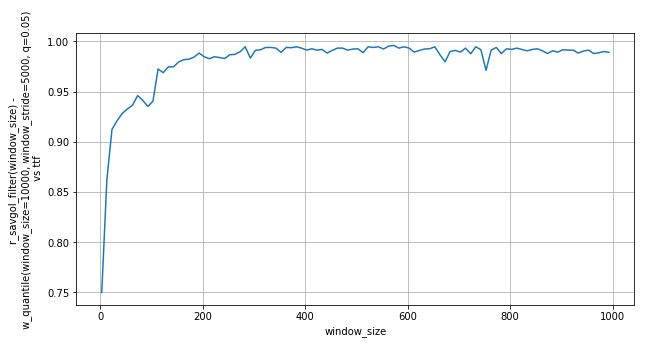

In [9]:
plt.figure(figsize=(10, 5))
# plt.ylabel("q05_std_rolling50")
plt.ylabel("r_savgol_filter(window_size) - \n w_quantile(window_size=10000, window_stride=5000, q=0.05) \n vs ttf")
plt.xlabel("window_size")
plt.grid(True)
plt.plot(windows, mutual_info_results)
plt.show()

/anaconda3/envs/p-sci/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


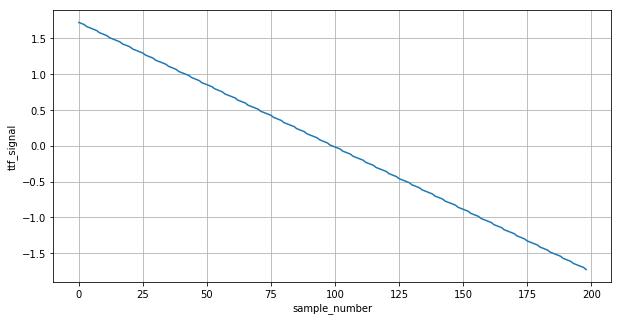

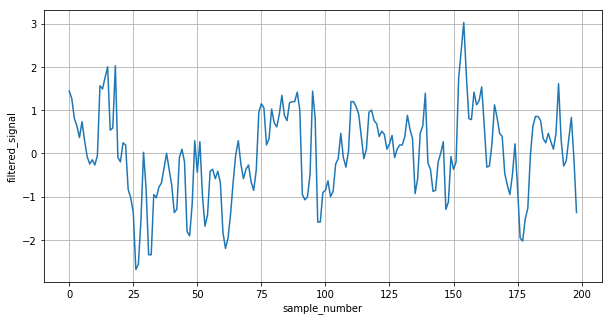

In [11]:
filtered_signal = Feature(df['s'], '../../data.nosync/')\
.r_savgol_filter(window_length=201, verbose=False)\
.w_quantile(window_size=10000, window_stride=5000, q=0.05, verbose=False)\
.data.values
ttf_signal = Feature(df['ttf'], '../../data.nosync/')\
.w_last_elem(window_size=10000, window_stride=5000, verbose=False)\
.data.values

temp_ = scaler.fit_transform(np.hstack((ttf_signal, filtered_signal)))
ttf_signal_scaled = temp_[:, 0]
filtered_signal_scaled = temp_[:, 1]
plt.figure(figsize=(10, 5))
# plt.ylabel("q05_std_rolling50")
plt.ylabel("ttf_signal")
plt.xlabel("sample_number")
plt.grid(True)
plt.plot(ttf_signal_scaled)
plt.show()
plt.figure(figsize=(10, 5))
# plt.ylabel("q05_std_rolling50")
plt.ylabel("filtered_signal")
plt.xlabel("sample_number")
plt.grid(True)
plt.plot(filtered_signal_scaled)
plt.show()

In [ ]:
windows = [i for i in range(1, 1001, 20)]
mutual_info_results = []
scaler = StandardScaler()

for window in tqdm(windows):
    filtered_signal = Feature(df['s'], '../../data/')\
    .r_std(window_size=window, verbose=False)\
    .w_quantile(window_size=10000, window_stride=5000, q=0.05, verbose=False)\
    .data.values
    ttf_signal = Feature(df['ttf'], '../../data/')\
    .w_last_elem(window_size=10000, window_stride=5000, verbose=False)\
    .data.values
    
    temp_ = scaler.fit_transform(np.hstack((ttf_signal, filtered_signal)))
    ttf_signal_scaled = temp_[:, 0]
    filtered_signal_scaled = temp_[:, 1]
    
    score = normalized_mutual_info_score(ttf_signal_scaled, filtered_signal_scaled, average_method="arithmetic")
    mutual_info_results.append(score)

In [ ]:
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.ylabel("q05_std_rolling50 vs ttf")
# plt.ylabel("r_std(window_size) - \n w_quantile(window_size=10000, window_stride=5000, q=0.05)")
plt.xlabel("window_size")
plt.plot(windows, mutual_info_results)
plt.show()

In [ ]:
# does not depend on window size
# windows = [i for i in range(3, 1001, 20)]
lags = [i for i in range(1, 1000, 10)]
mutual_info_results = []
scaler = StandardScaler()

for lag in tqdm(lags):
    filtered_signal = Feature(df['s'], '../../data/')\
    .r_std(window_size=25, verbose=False)\
    .w_autocorrelation(window_size=10000, window_stride=5000, lag=lag, verbose=False)\
    .data.values
    ttf_signal = Feature(df['s'], '../../data/')\
    .w_last_elem(window_size=10000, window_stride=5000, verbose=False)\
    .data.values
    
    temp_ = scaler.fit_transform(np.hstack((ttf_signal, filtered_signal)))
    ttf_signal_scaled = temp_[:, 0]
    filtered_signal_scaled = temp_[:, 1]
    
    score = normalized_mutual_info_score(ttf_signal_scaled, filtered_signal_scaled, average_method="arithmetic")
    mutual_info_results.append(score)

In [ ]:
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.ylabel("autocorr_std_rolling50 vs ttf")
# plt.ylabel("r_std(window_size) - \n w_quantile(window_size=10000, window_stride=5000, q=0.05)")
plt.xlabel("lag value")
plt.plot(lags, mutual_info_results)
plt.show()

In [ ]:
test = Feature(df.drop(['ttf'], axis=1), '../../data.nosync/')\
.w_periodogram(window_size=100, window_stride=100, N=1000)\

In [ ]:
test.w_std(window_size=100, window_stride=100).data

In [ ]:
p = Feature(df['ttf'], '../../data/')
p = getattr(p, 'mean')(window_size=100, window_stride=100)

In [ ]:
temp = [np.array([1, 2, 3]), np.array([2, 3, 4])]
dict(zip(["a", "b"], temp))

In [ ]:
funcs = {"functions": {"periodogram": {"N": 1000}, "mean": {}}}
for func_name, func_params in funcs['functions'].items():
    print(func_name, func_params)

In [ ]:
%%time 

filepath = '../../data/test/seg_00030f.csv'

df = pd.read_csv(filepath, 
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}, 
                 skiprows=1, 
                 names=['s', 'ttf'])